In [ ]:
import sys
sys.path.append('..')

In [3]:
import torch
import PIL
import os
import cv2
from scipy import ndimage
import numpy as np
from PIL import Image
import torchvision
from torchvision import transforms
from src.efficientunet import *
import random
import matplotlib.pyplot as plt
from src.dataset import  RetinalDataset
from src.model import get_torchvision_model
import src.segmentation_models_pytorch as smp
from scipy.ndimage.morphology import binary_dilation, binary_erosion

SCALE = 256

## Load model

In [4]:
model = get_torchvision_model("Se_resnext50", True, 1, "focal")

In [5]:
state_dict = torch.load("models/Se_resnext50-920eef84.pth",  map_location=torch.device('cpu'))
state_dict = state_dict["state"]
model.load_state_dict(state_dict)

<All keys matched successfully>

## Load depedencies

In [6]:
# Transformation
from src.transformation import train_transformation, inference_transformation

# FAZ Preprocessing
from src.dataset import FAZ_Preprocess

# Level Set
from src.levelset import *

# Metrics
from src.metrics import scoring

# Handy ultility function
from src.utils import binarize_phi

## Predict and Visualization: step by step

### Load image

(<matplotlib.image.AxesImage at 0x16f4deda0>,
 Text(0.5, 1.0, 'Original image'),
 (-0.5, 509.5, 511.5, -0.5))

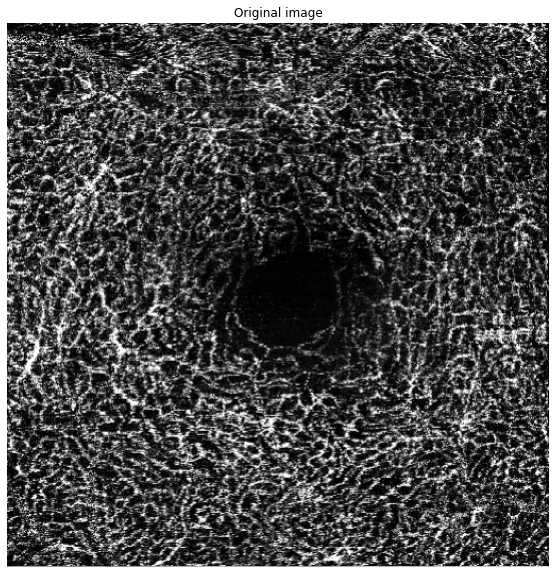

In [9]:
# Load image
#impath = '../Update_26-03-2020/POS_G 0004A DVC.png'
impath = '../Update_26-03-2020/POS_G 0008A DVC.PNG'
im = plt.imread(impath)


plt.figure(figsize=(15,10)), plt.axis('off')
plt.imshow(im), plt.title('Original image'), plt.axis('off')

### Enhanced by Hessian-based filter

In [10]:
# Loading image and ENHANCE by Hessian-based filter
enhanced = FAZ_Preprocess(impath,[0.5,1, 1.5, 2, 2.5],1, 2).vesselness2d()

(<matplotlib.image.AxesImage at 0x16d2782e8>,
 (-0.5, 509.5, 511.5, -0.5),
 Text(0.5, 1.0, 'Enhanced by Hessian filter'))

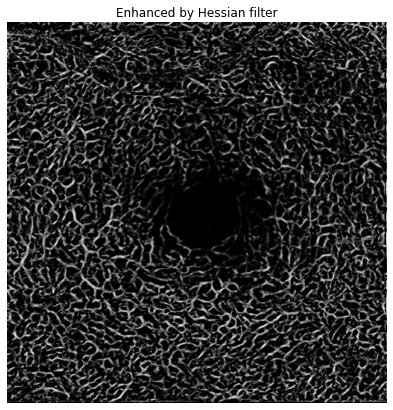

In [11]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced, cmap='gray'), plt.axis('off'), plt.title('Enhanced by Hessian filter')

### Segment (predict) using DNN

In [12]:
# Transformation (to tensor)
tensor_transform = transforms.Compose([
    transforms.Resize((SCALE, SCALE)),
    transforms.ToTensor()
])

enhanced_ts = tensor_transform(Image.fromarray(enhanced.astype(np.float32)*255).convert("RGB"))

enhanced_ts.shape

torch.Size([3, 256, 256])

In [13]:
model.eval()
mask = enhanced_ts.unsqueeze(0)
mask = model(mask)
mask = (mask.to("cpu").detach().numpy() > 0.6) * 1
mask = mask.reshape((SCALE, SCALE))

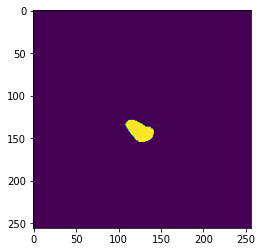

In [14]:
plt.imshow(mask)

((-0.5, 255.5, 255.5, -0.5), Text(0.5, 1.0, 'Mask predicted by UNet'))

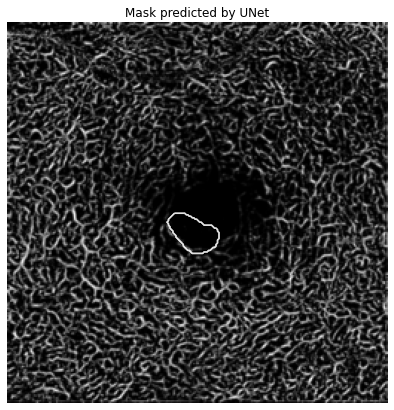

In [15]:
enhanced_scaled = enhanced_ts.permute(1,2,0).numpy()
enhanced_scaled =  cv2.cvtColor(enhanced_scaled, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(mask, cmap='gray', alpha=0.3)
plt.contour(mask, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet')

### LEVEL SET

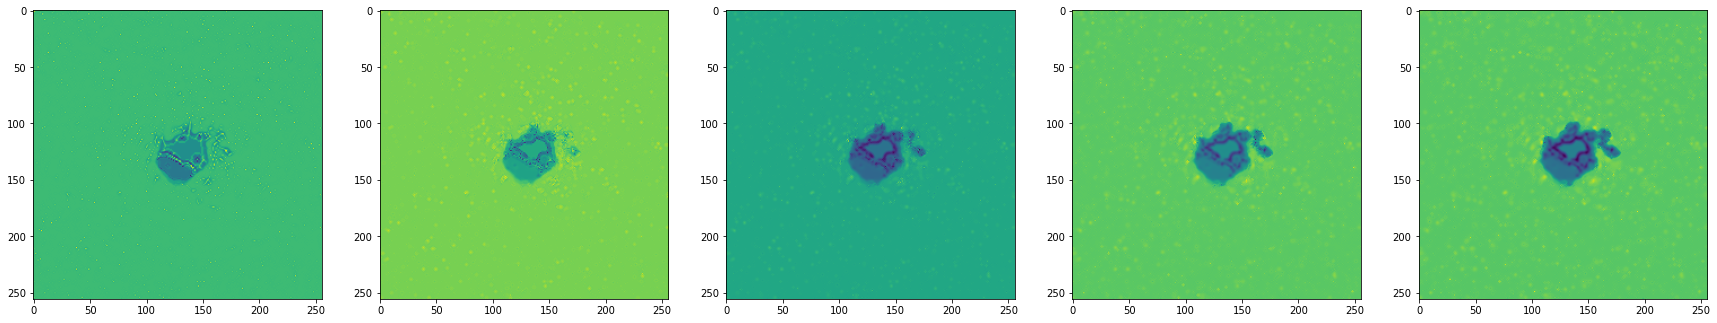

In [18]:
phi, delta = levelset(enhanced_ts, mask, 5, isplot=True)

(<matplotlib.image.AxesImage at 0x172464748>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by DNN, erosed a little, after LEVELSET'))

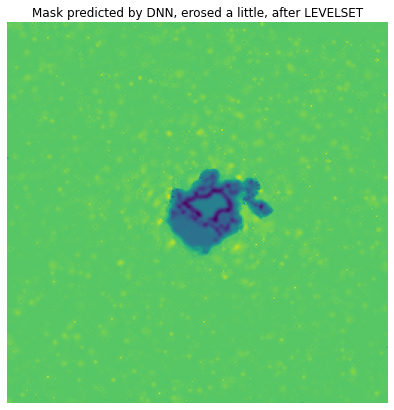

In [19]:
plt.figure(figsize=(13,7))
plt.imshow(phi), plt.axis('off'), plt.title('Mask predicted by DNN, erosed a little, after LEVELSET')

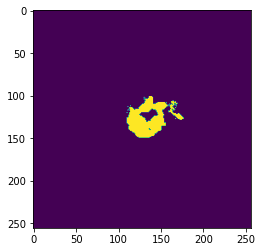

In [20]:
binary_phi = binarize_phi(phi)
plt.imshow(binary_phi)

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

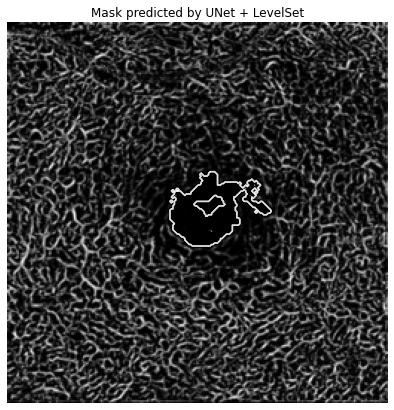

In [21]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(binary_phi, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')

### Erosion + Levelset

In [25]:
# EROSE the output mask
kernel1 = np.array([[0, 0, 1, 0, 0],
           [0, 1, 1, 1, 0],
           [1, 1, 1, 1, 1],
           [0, 1, 1, 1, 0],
           [0, 0, 1, 0, 0]])   
kernel2 = np.ones((5,5))

erosed_mask = binary_erosion(mask.copy(), kernel2, iterations = 3)

(<matplotlib.image.AxesImage at 0x173b337f0>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by DNN, erosed a little'))

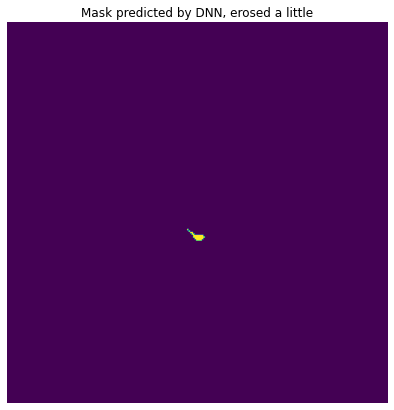

In [26]:
plt.figure(figsize=(13,7))
plt.imshow(erosed_mask), plt.axis('off'), plt.title('Mask predicted by DNN, erosed a little')

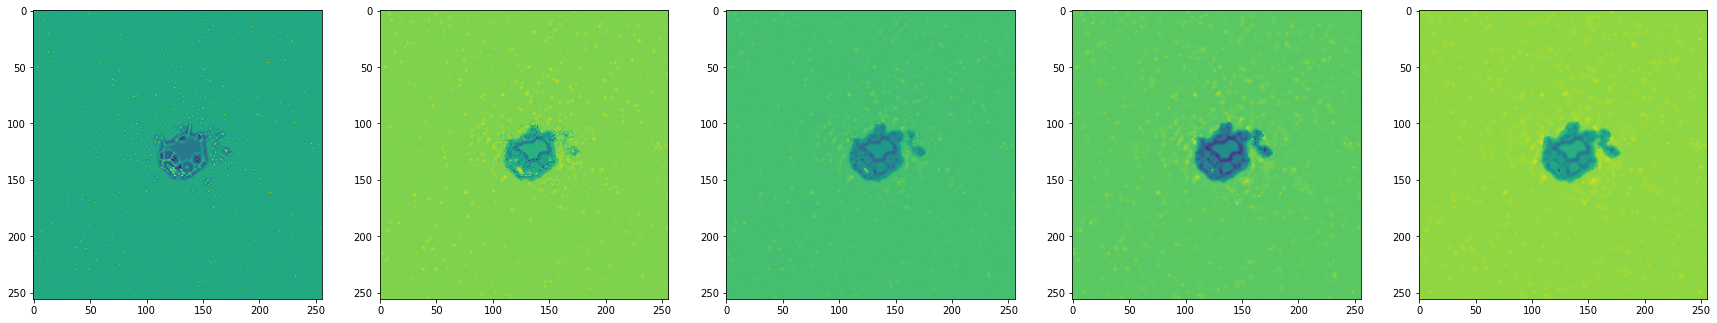

In [27]:
phi2, delta = levelset(enhanced_ts, erosed_mask, 5, isplot=True)

In [28]:
binary_phi2 = binarize_phi(phi2)

((-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Mask predicted by UNet + LevelSet'))

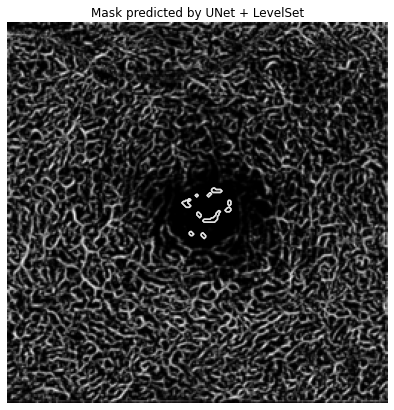

In [29]:
plt.figure(figsize=(13,7))
plt.imshow(enhanced_scaled, cmap='gray')
#plt.imshow(new_phi, cmap='gray', alpha=0.3)
plt.contour(binary_phi2, levels=np.logspace(-4.7, -3., 10), colors='white', alpha=0.2)
plt.axis('off'), plt.title('Mask predicted by UNet + LevelSet')